# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

C:\Users\Noel\Anaconda3\envs\MaskRCNN\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

print(len(class_names))

81


## Run Object Detection

Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


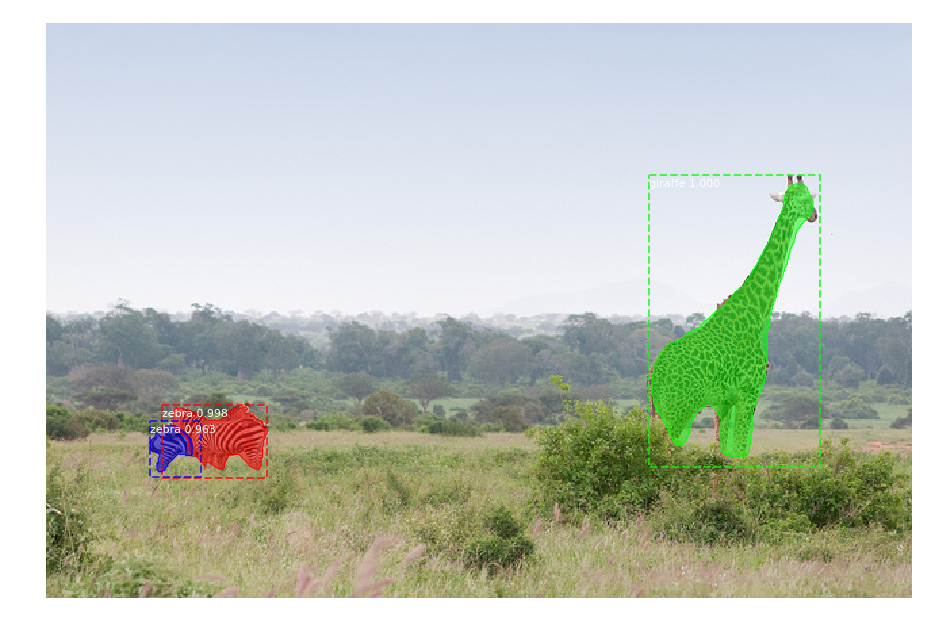

425


In [41]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
filetitle = 'giraffe'
exten = '.jpg'
filename = os.path.join(IMAGE_DIR, filetitle + exten)
image = skimage.io.imread(filename)



results = model.detect([image], verbose=1)


r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
print(len(r['masks']))

In [42]:
print('done')

done


In [43]:
if not os.path.exists("C:\\Users\\Noel\\Pictures\\" + filetitle):
        os.makedirs("C:\\Users\\Noel\\Pictures\\" + filetitle)
for i in range(r['masks'].shape[2]):
    skimage.io.imsave("C:\\Users\\Noel\\Pictures\\" + filetitle + "\\" + filetitle + class_names[r['class_ids'][i]] + str(i) + exten, 255 * r['masks'][:,:,i])

C:\Users\Noel\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\io\_io.py:129: UserWarning: C:\Users\Noel\Pictures\giraffe\giraffegiraffe0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Noel\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\util\dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Noel\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\util\dtype.py:171: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Users\Noel\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\io\_io.py:129: UserWarning: C:\Users\Noel\Pictures\giraffe\giraffezebra1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\Noel\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\io\_io.py:129: UserWarning: C:\Users\Noel\Pi

In [44]:
from skimage import transform, util
from skimage import filters, color

def removeMask(mask, energy):
    return np.subtract(energy, 10000*mask)
    
def addMask(mask, energy):
    return np.add(energy, 1000*mask)

print(len(r['masks'][0,0,:]))
for i in range(len(r['masks'][0,0,:])):
    mask = r['masks'][:,:,i]
    pixs = (r['rois'][i,3] - r['rois'][i,1], r['rois'][i,2] - r['rois'][i,0])
    id = class_names[r['class_ids'][i]] + str(i) + '_removed'
    energy = filters.roberts(color.rgb2gray(image))
    energy = removeMask(mask,energy)
    out = transform.seam_carve(image, energy, 'vertical', pixs[0])
    skimage.io.imsave("C:\\Users\\Noel\\Pictures\\" + filetitle + "\\" + id + '.jpg', out)


3


C:\Users\Noel\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [45]:
for i in range(len(r['masks'][0,0,:])):
    mask = r['masks'][:,:,i]
    pixs = (r['rois'][i,3] - r['rois'][i,1], r['rois'][i,2] - r['rois'][i,0])
    id = class_names[r['class_ids'][i]] + str(i) + '_removed'
    energy = filters.roberts(color.rgb2gray(image))
    energy = removeMask(mask,energy)
    for j in range(len(r['masks'][0,0,:])):
        if j!=i:
            energy = addMask(r['masks'][:,:,j], energy)
    out = transform.seam_carve(image, energy, 'vertical', pixs[0])
    skimage.io.imsave("C:\\Users\\Noel\\Pictures\\" + filetitle + "\\" + id + 'plus.jpg', out)

C:\Users\Noel\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
